In [1]:
from scripts.halo_analysis_scripts import *
from scripts.analytic_modeling import Simulation
from astropy import units as un, constants as cons
from joblib import Parallel, delayed
import matplotlib.colors as colors
from pprint import pprint
%matplotlib inline
plt.style.reload_library()
import smplotlib
from scipy.interpolate import interp1d, splrep, splev
import pandas as pd

import WiersmaCooling as Cool
import cooling_flow as CF


import matplotlib as mpl
plt.rcParams.update({'font.size': 18})
mpl.rcParams['mathtext.default'] = 'regular'

from cycler import cycler
mpl.rcParams['axes.prop_cycle'] = cycler(color=COLOR_SCHEME)

from datetime import datetime
from scipy.spatial import cKDTree
import iht

In [52]:
v = np.array(
    [
        [0, -1, 0],
        [1, 0, 0],
        [1, 0, 0]
    ]
)

r = np.array(
    [
        [1, 0, 0],
        [0, 1, 0],
        [0, -1, 0]
    ]
)

In [53]:
iht.spherical_velocities(v, r)

(array([0.000000e+00, 6.123234e-17, 6.123234e-17]),
 array([0.00000000e+00, 3.74939946e-33, 3.74939946e-33]),
 array([-1., -1.,  1.]))

 * Detected change in '/home/ias627/projects/massive_halos/scripts/analytic_modeling.py', reloading
 * Restarting with stat


Launching Firefly at: http://localhost:5500
from directory /home/ias627/tools/Firefly/src/firefly
======= socket connected
======= connected {'data': 'GUI connected!'}
======= connected {'data': 'Viewer connected!'}
======= in room default_Firefly_AMG_ABG
======= in room default_Firefly_AMG_ABG
======= receiving data from server ...
======= size of data 313463672
======= showing loader
======= sending data to viewer ...
/home/ias627/tools/Firefly/src/firefly/static/data/Data/DataPGroup_0000.json 9958597
/home/ias627/tools/Firefly/src/firefly/static/data/Data/DataPGroup_0001.json 9957965
/home/ias627/tools/Firefly/src/firefly/static/data/Data/DataPGroup_0002.json 9958108
/home/ias627/tools/Firefly/src/firefly/static/data/Data/DataPGroup_0003.json 9958090
/home/ias627/tools/Firefly/src/firefly/static/data/Data/DataPGroup_0004.json 9956628
/home/ias627/tools/Firefly/src/firefly/static/data/Data/DataPGroup_0005.json 9957259
/home/ias627/tools/Firefly/src/firefly/static/data/Data/DataPGroup

In [2]:
keys_to_extract = {
0:['Coordinates', 'Masses', 'Density', 
'Temperature', 'InternalEnergy', 'CosmicRayEnergy', 
'Velocities', 'Metallicity', 'SoundSpeed', 'CoolingRate', 'SmoothingLength', 'MagneticField', 'ElectronAbundance'],
1:['Coordinates', 'Masses', 'Velocities'],
2:['Coordinates', 'Masses', 'Velocities'],
4:['Coordinates', 'Masses', 'Velocities'],
5:['Coordinates', 'Masses', 'Velocities']
}

# p = load_allparticles('/projects/b1026/isultan/metal_diffusion/m12m_r7100/', 600, 
#                 particle_types=sorted(keys_to_extract.keys()), 
#                 keys_to_extract=keys_to_extract, 
#                 Rvir='None', loud=0)

# p = load_allparticles('/projects/b1026/snapshots/fire3_m12_new/m12j_r7100/', 500, 
#                 particle_types=sorted(keys_to_extract.keys()), 
#                 keys_to_extract=keys_to_extract, 
#                 Rvir='None', loud=0)

p = load_allparticles('/projects/b1026/isultan/metal_diffusion/m12i_r7100', 600, 
                particle_types=sorted(keys_to_extract.keys()), 
                keys_to_extract=keys_to_extract, 
                Rvir='None', loud=0)

In [3]:
p2 = load_allparticles('/projects/b1026/isultan/metal_diffusion/m12b_r7100', 600, 
                particle_types=sorted(keys_to_extract.keys()), 
                keys_to_extract=keys_to_extract, 
                Rvir='None', loud=0)

In [4]:
p = load_allparticles('/projects/b1026/isultan/fire3/m13h206_m3e5_MHD_fire3_fireBH_Sep182021_crdiffc690_sdp1e10_gacc31_fa0.5/', 60, 
                particle_types=sorted(keys_to_extract.keys()), 
                keys_to_extract=keys_to_extract, 
                Rvir='None', loud=0)

In [34]:
# m12i = p
m12b = p

In [20]:
velC = iht.velocity_COM(p)
print(velC)

[-72.03621  -27.455648 -94.1308  ]


In [21]:
for k in p.keys():
    print(k)
    p[k]['Coordinates'] -= p[k]['posC']
    p[k]['Velocities'] -= velC

0
1
2
4


In [16]:
R = iht.rotate_coords(p, p[0]['Rvir'])
tv = np.dot(tv, R.T)

In [8]:
def find_angmom_vector(pos, vel, mass, normalize=True):
    angmom = np.sum( np.cross(pos, vel) * mass[:, None], axis=0 )
    if normalize: angmom /= np.linalg.norm(angmom)
    return angmom

def Rmatrix(u, theta):
    c = np.cos(theta)
    s = np.sin(theta)
    ux, uy, uz = u
    
    R= [
        [c+ux**2*(1-c), ux*uy*(1-c)-uz*s, ux*uz*(1-c)+uy*s],
        [uy*ux*(1-c)+uz*s, c+uy**2*(1-c), uy*uz*(1-c)-ux*s],
        [uz*ux*(1-c)-uy*s, uz*uy*(1-c)+ux*s, c+uz**2*(1-c)]
    ]
    return np.array(R)

def rotate_coords(pdata, Rvirial, Rgal=0.1):
    '''Given dictionary of particles, rotates coordinates and velocities such that the new z-axis is the axis of rotation of the galaxy.
    `pdata[k]['Coordinates']` and `pdata[k]['Velocities']` are changed to be the new rotated coordinates.
    
    `pdata[k]['Coordinates']` and `pdata[k]['Velocities']` must be defined relative to the center of halo before calling this function.
    
    The axis of rotation of the galaxy is calculated as the total angular momentum of all star particles (`pdata[4]`) within `Rgal`*`Rvirial`.
    `Rvirial` must have the same units as `pdata[k]['Coordinates']`.
    '''
    # Net angular momentum vector of all star particles within Rgal*Rvirial
    idx = np.linalg.norm(pdata[4]['Coordinates'], axis=1) < (Rgal*Rvirial)
    j = find_angmom_vector(pdata[4]['Coordinates'][idx], pdata[4]['Velocities'][idx], pdata[4]['Masses'][idx])
    
    u = np.cross(j, [0,0,1])
    u /= np.linalg.norm(u)
    theta = np.arccos(j[2])
    R = Rmatrix(u, theta)
    
    for k in pdata.keys():
        pdata[k]['Coordinates'] = np.dot(pdata[k]['Coordinates'], R.T)
        pdata[k]['Velocities'] = np.dot(pdata[k]['Velocities'], R.T)

In [43]:
import utilities.coordinate as utc
def rotate_coords(p, Rgal=0.1):
    def find_angmom_vector(pos, vel, mass):
        angmom = np.sum(mass.reshape(len(mass),1)*np.cross(pos, vel),0)/np.sum(mass)
        return angmom/np.sqrt(angmom[0]**2+angmom[1]**2+angmom[2]**2)
    
    pos_halo = np.concatenate([p[k]['Coordinates'][p[k]['r_scaled']<Rgal] for k in [4]])
    vel_halo = np.concatenate([p[k]['Velocities'][p[k]['r_scaled']<Rgal] for k in [4]])
    mass_halo = np.concatenate([p[k]['Masses'][p[k]['r_scaled']<Rgal] for k in [4]])
    
    angmom_vec = find_angmom_vector(pos_halo, vel_halo, mass_halo)
    vec2 = np.array([angmom_vec[2], 0, -angmom_vec[0]])
    vec2 = vec2/np.sqrt(vec2[0]**2 + vec2[1]**2 + vec2[2]**2)
    vec3 = np.cross(angmom_vec, vec2)
    
    for k in p.keys():
        p[k]['Coordinates'] = utc.get_coordinates_rotated(p[k]['Coordinates'], rotation_tensor=np.array([vec2, vec3,angmom_vec]))
        p[k]['Velocities'] = utc.get_coordinates_rotated(p[k]['Velocities'], rotation_tensor=np.array([vec2, vec3,angmom_vec]))
    return angmom_vec

In [32]:
def find_angmom_vector(coordinates, velocities, masses):
    L = np.sum(np.cross(coordinates, masses[:, np.newaxis] * velocities), axis=0)
    return L / np.linalg.norm(L)

def Rmatrix(u, theta):
    cos_theta = np.cos(theta)
    sin_theta = np.sin(theta)
    u_x, u_y, u_z = u
    R = np.array([
        [cos_theta + u_x**2 * (1 - cos_theta), u_x * u_y * (1 - cos_theta) - u_z * sin_theta, u_x * u_z * (1 - cos_theta) + u_y * sin_theta],
        [u_y * u_x * (1 - cos_theta) + u_z * sin_theta, cos_theta + u_y**2 * (1 - cos_theta), u_y * u_z * (1 - cos_theta) - u_x * sin_theta],
        [u_z * u_x * (1 - cos_theta) - u_y * sin_theta, u_z * u_y * (1 - cos_theta) + u_x * sin_theta, cos_theta + u_z**2 * (1 - cos_theta)]
    ])
    return R

def rotate_coords(pdata, Rvirial, Rgal=0.1, threshold=1e-6):
    idx = np.linalg.norm(pdata[4]['Coordinates'], axis=1) < (Rgal * Rvirial)
    j = find_angmom_vector(pdata[4]['Coordinates'][idx], pdata[4]['Velocities'][idx], pdata[4]['Masses'][idx])
    
    if np.allclose(j, [0, 0, 1], atol=threshold):
        return np.eye(3), j

    u = np.cross([0, 0, 1], j)
    if np.linalg.norm(u) == 0:
        u = np.array([1, 0, 0])  # Handle the edge case where j is already aligned with z-axis
    else:
        u /= np.linalg.norm(u)

    theta = np.arccos(np.clip(j[2], -1, 1))  # Ensure the value is within valid range for arccos
    R = Rmatrix(u, theta)
    
    for k in pdata.keys():
        pdata[k]['Coordinates'] = np.dot(pdata[k]['Coordinates'], R.T)
        pdata[k]['Velocities'] = np.dot(pdata[k]['Velocities'], R.T)
    
    # Recompute the angular momentum vector to check the alignment
    j_new = find_angmom_vector(pdata[4]['Coordinates'][idx], pdata[4]['Velocities'][idx], pdata[4]['Masses'][idx])
    
    if not np.allclose(j_new, [0, 0, 1], atol=threshold):
        # Apply a corrective small rotation if not perfectly aligned
        u = np.cross(j_new, [0, 0, 1])
        if np.linalg.norm(u) == 0:
            u = np.array([1, 0, 0])  # Handle the edge case
        else:
            u /= np.linalg.norm(u)
        theta = np.arccos(np.clip(j_new[2], -1, 1))
        R_corr = Rmatrix(u, theta)
        
        for k in pdata.keys():
            pdata[k]['Coordinates'] = np.dot(pdata[k]['Coordinates'], R_corr.T)
            pdata[k]['Velocities'] = np.dot(pdata[k]['Velocities'], R_corr.T)
    
    return R, j

In [13]:
from scipy.spatial.transform import Rotation as R
def rotate_coords(pdata, Rvirial, Rgal=0.1):
    """
    Given a dictionary of particles, rotates coordinates and velocities such that the new z-axis is 
    the axis of rotation of the galaxy. `pdata[k]['Coordinates']` and `pdata[k]['Velocities']` 
    are changed to be the new rotated coordinates.
    
    `pdata[k]['Coordinates']` and `pdata[k]['Velocities']` must be defined relative to the center of 
    the halo before calling this function.
    
    The axis of rotation of the galaxy is calculated as the total angular momentum of all star particles 
    (`pdata[4]`) within `Rgal`*`Rvirial`. `Rvirial` must have the same units as `pdata[k]['Coordinates']`.
    """
    # Net angular momentum vector of all star particles within Rgal*Rvirial
    idx = np.linalg.norm(pdata[4]['Coordinates'], axis=1) < (Rgal * Rvirial)
    j = iht.find_angmom_vector(pdata[4]['Coordinates'][idx], pdata[4]['Velocities'][idx], pdata[4]['Masses'][idx])
    
    # Define the rotation to align j with the z-axis
    z_axis = np.array([0, 0, 1])
    axis = np.cross(j, z_axis)
    
    if np.linalg.norm(axis) == 0:
        # j is already aligned with z-axis
        return np.eye(3), j
    
    axis /= np.linalg.norm(axis)
    angle = np.arccos(np.dot(j, z_axis) / np.linalg.norm(j))
    
    r = R.from_rotvec(angle * axis)
    
    # Apply the rotation to coordinates and velocities
    for k in pdata.keys():
        pdata[k]['Coordinates'] = r.apply(pdata[k]['Coordinates'])
        pdata[k]['Velocities'] = r.apply(pdata[k]['Velocities'])
    
    return r.as_matrix(), j

In [24]:
idx = np.linalg.norm(p[4]['Coordinates'], axis=1) < (0.1*p[4]['Rvir'])
iht.find_angmom_vector(p[4]['Coordinates'][idx], p[4]['Velocities'][idx], p[4]['Masses'][idx])

array([-0.00114525, -0.00128091,  0.99999852])

In [23]:
iht.rotate_coords(p, p[4]['Rvir'])

In [31]:
@njit
def spherical_velocities(vp, rp):
    '''Given velocity v and position r cartesian arrays, calculates vrad, vtheta, vphi (each in same units as v).
    For N particles, v is Nx3 array of cartestian particle velocities, and r is a Nx3 array of carestian particle positions.
    `v` and `r` must be defined relative to the center of halo before calling this function.
    '''
    N = vp.shape[0]
    vrad = np.zeros(N)
    vtheta = np.zeros(N)
    vphi = np.zeros(N)
    for i in range(N):
        v = vp[i]
        r = rp[i]
        theta = np.arctan2( np.sqrt(r[0]**2 + r[1]**2), r[2] )
        phi = np.arctan2( r[1], r[0] )

        vrad[i] = v[0]*np.sin(theta)*np.cos(phi) + v[1]*np.sin(theta)*np.sin(phi) + v[2]* np.cos(theta)
        vtheta[i] = v[0]*np.cos(theta)*np.cos(phi) + v[1]* np.cos(theta)*np.sin(phi) + v[2]*-np.sin(theta)
        vphi[i] = v[0]*-np.sin(phi) + v[1]*np.cos(phi)
    return vrad, vtheta, vphi

In [32]:
p[0]['vrad'], p[0]['vtheta'], p[0]['vphi'] = spherical_velocities(vp=p[0]['Velocities'], rp=p[0]['Coordinates'])
var_sp = 1/3 * ( np.var(p[0]['vrad']) + np.var(p[0]['vtheta']) + np.var(p[0]['vphi']) )
var_ct = 1/3 * ( np.var(p[0]['Velocities'][:,0]) + np.var(p[0]['Velocities'][:,1]) + np.var(p[0]['Velocities'][:,2]) )

In [6]:
var_sp, var_ct

(4064.2858072916665, 3839.7037760416665)

In [17]:
var_sp, var_ct

(3874.6963528526694, 3839.7021214631177)

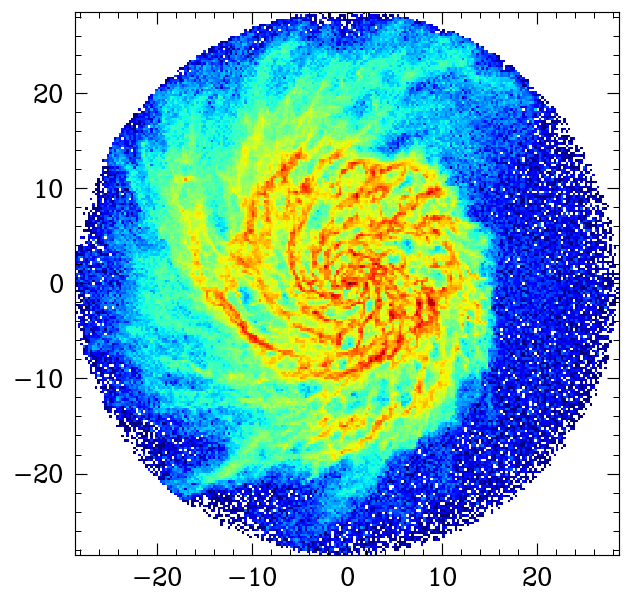

In [33]:
idx = (p[0]['r_scaled'] < .1)&(np.abs(p[0]['Coordinates'][:,2]) < 15)

from matplotlib.colors import LogNorm
h_mt,xedges,yedges = np.histogram2d(
    p[0]['Coordinates'][:,0][idx],
    p[0]['Coordinates'][:,1][idx],
    bins=225,
    weights=p[0]['Masses'][idx])#*p[4]['Temperature'][idx])

plt.pcolormesh(xedges,yedges, (h_mt).T, norm=LogNorm())
plt.gca().set_aspect(1)a
# plt.quiver([0], [0], tv[0:1], tv[1:2], scale=5, color='k', zorder=10)

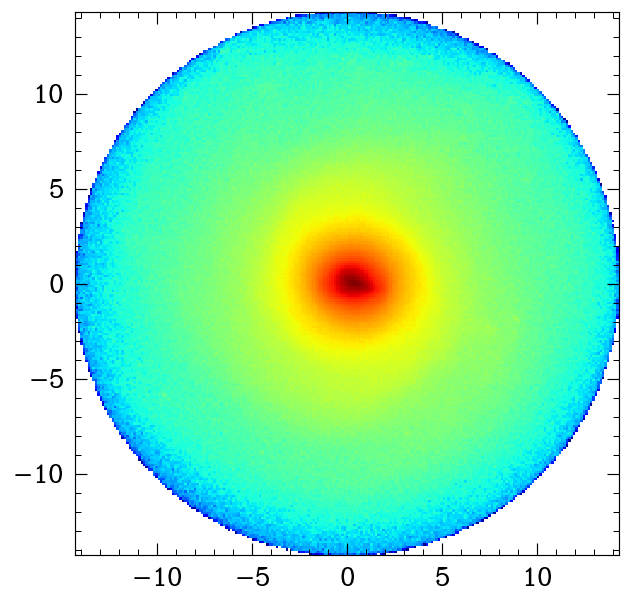

In [41]:
p = m12b
idx = (p[4]['r_scaled'] < .05)

from matplotlib.colors import LogNorm
h_mt,xedges,yedges = np.histogram2d(
    p[4]['Coordinates'][:,0][idx],
    p[4]['Coordinates'][:,1][idx],
    bins=225,
    weights=p[4]['Masses'][idx])#*p[4]['Temperature'][idx])

plt.pcolormesh(xedges,yedges, (h_mt).T, norm=LogNorm())
plt.gca().set_aspect(1)
# plt.quiver([0], [0], tv[0:1], tv[1:2], scale=5, color='k', zorder=10)

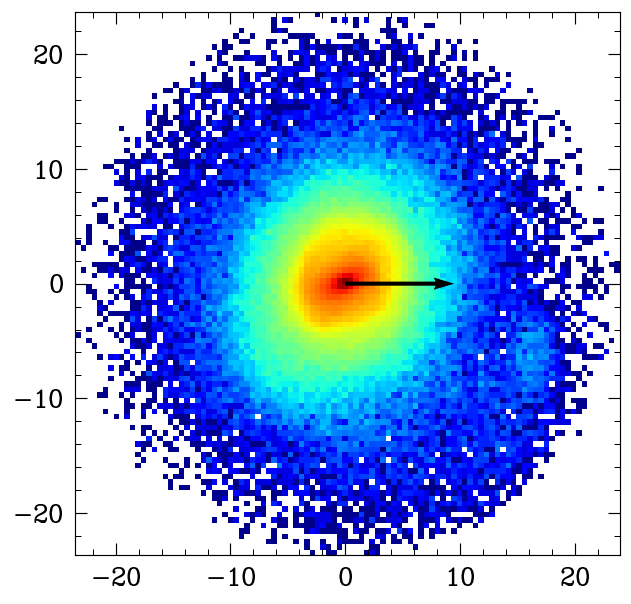

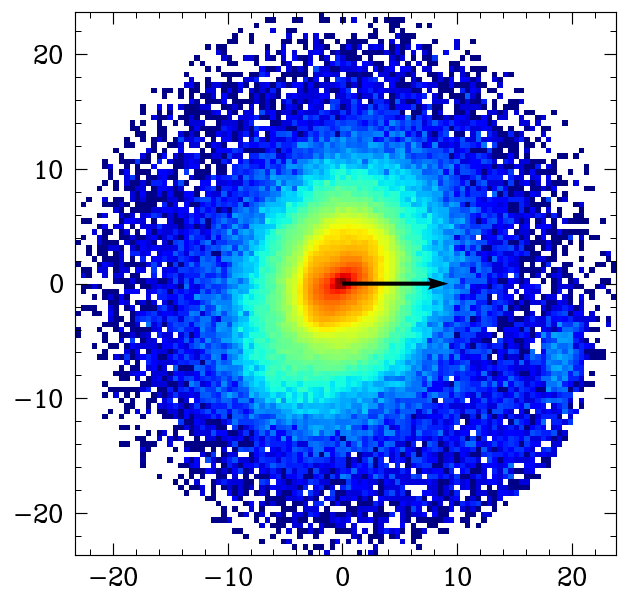

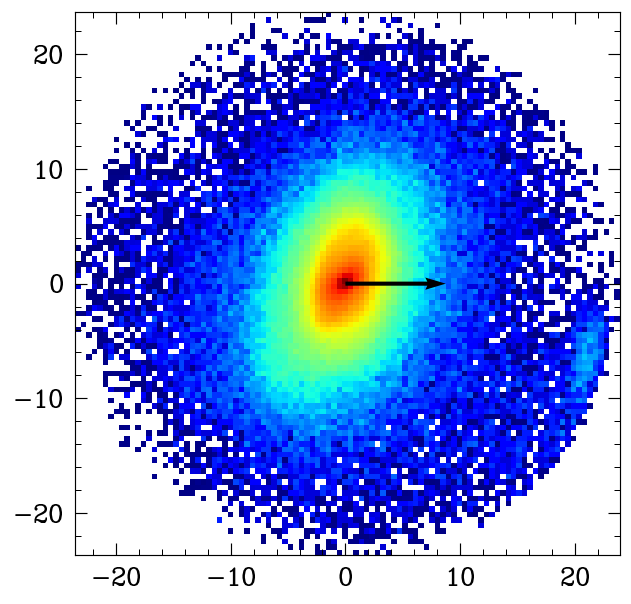

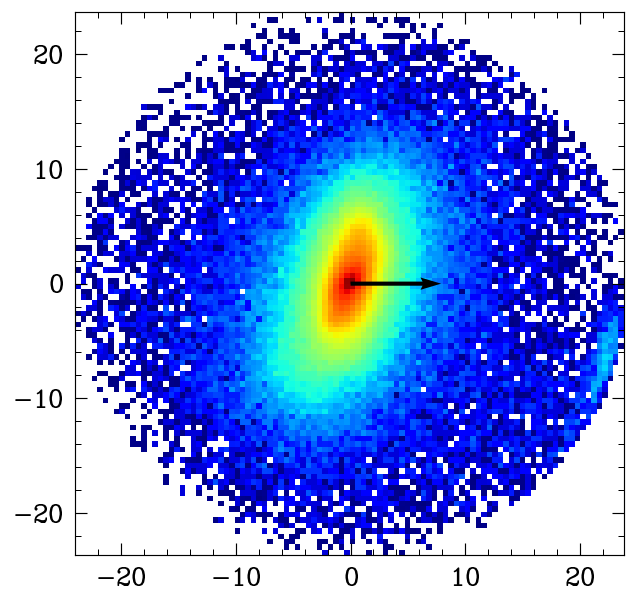

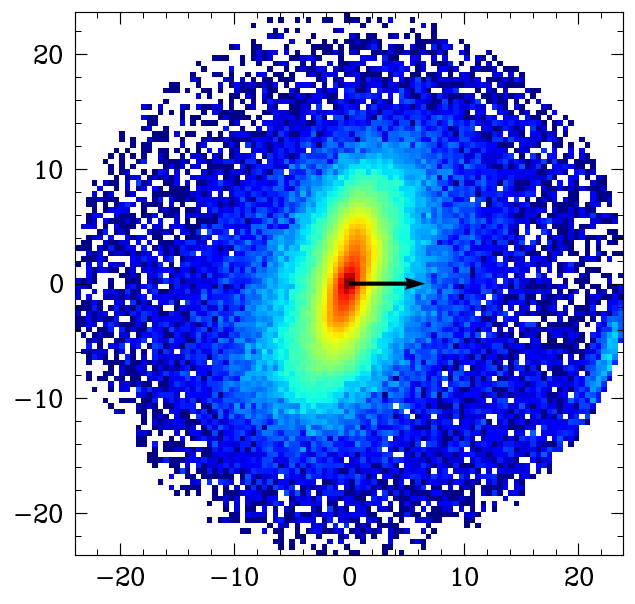

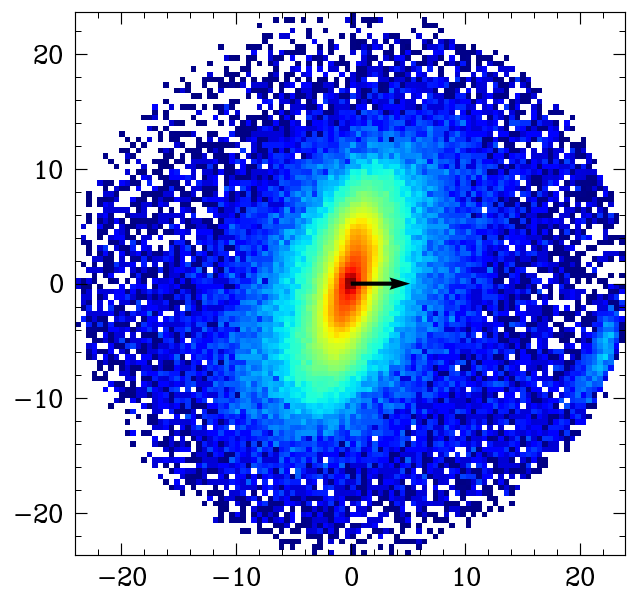

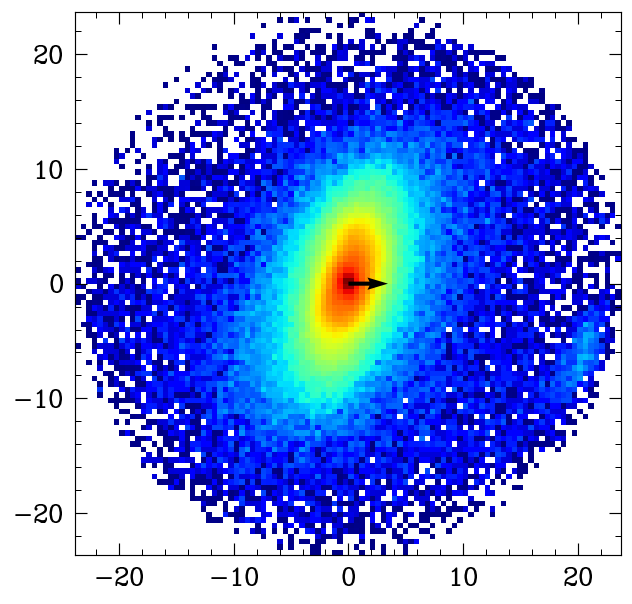

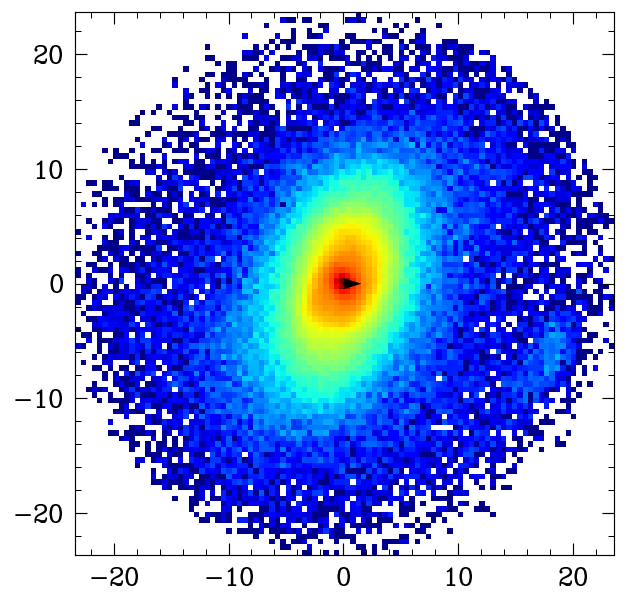

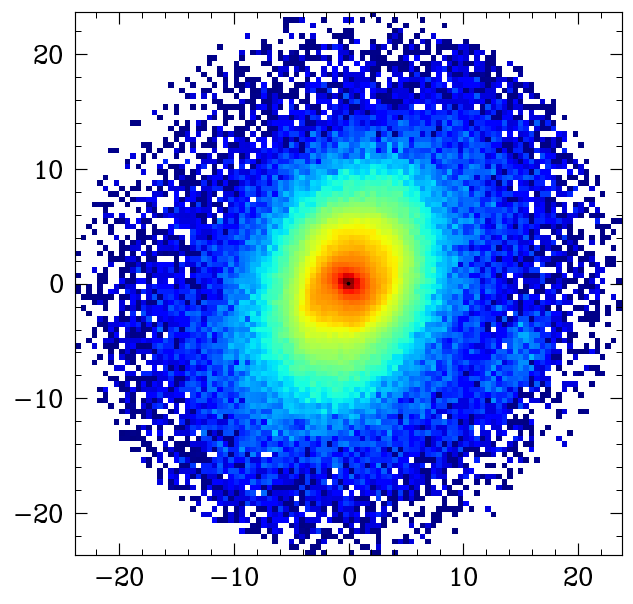

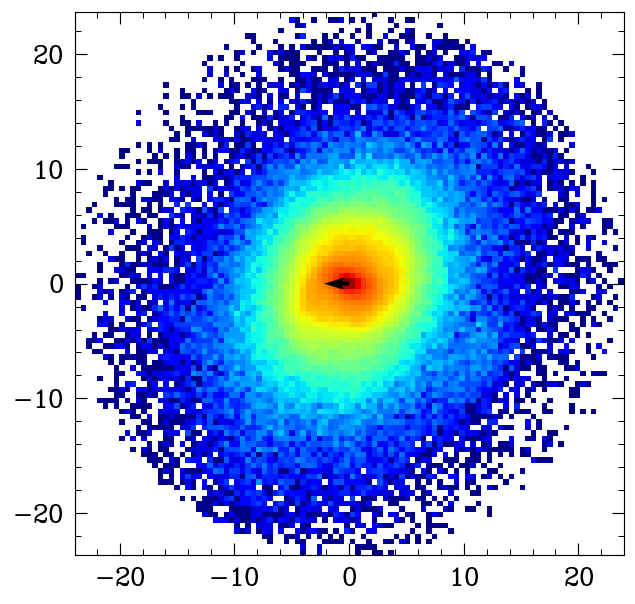

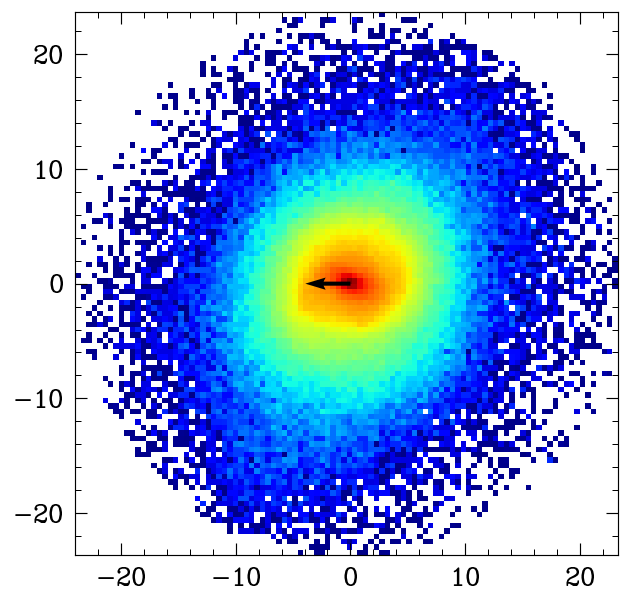

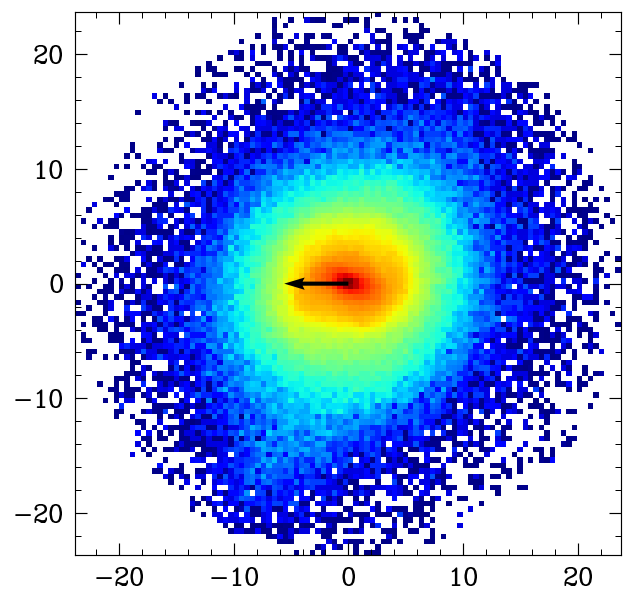

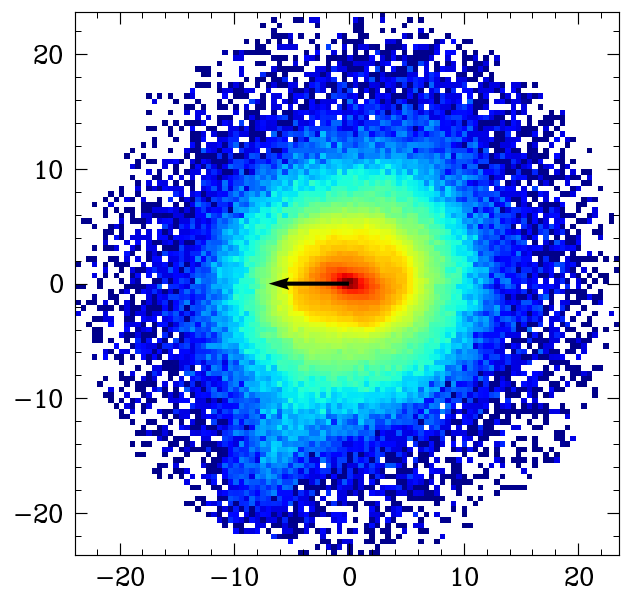

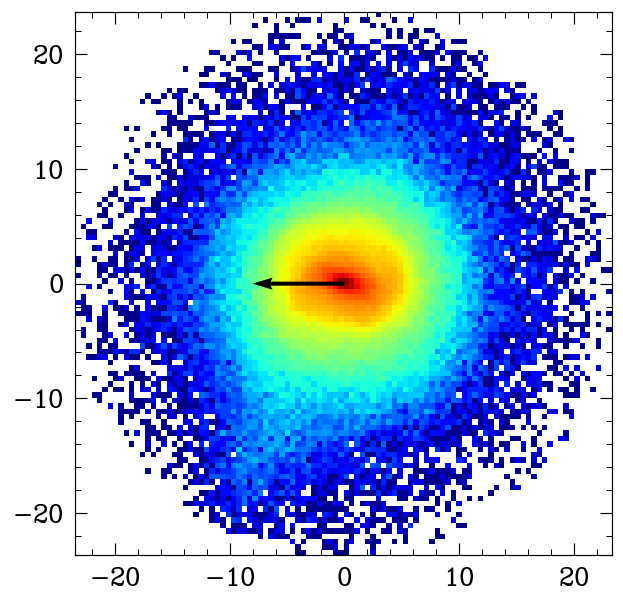

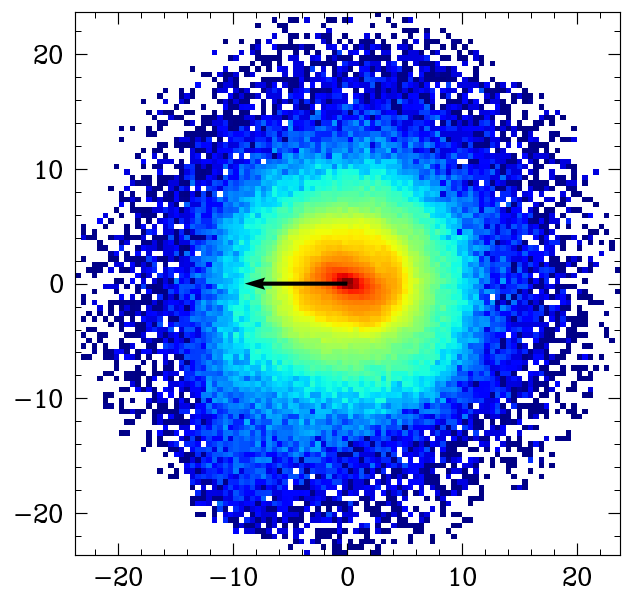

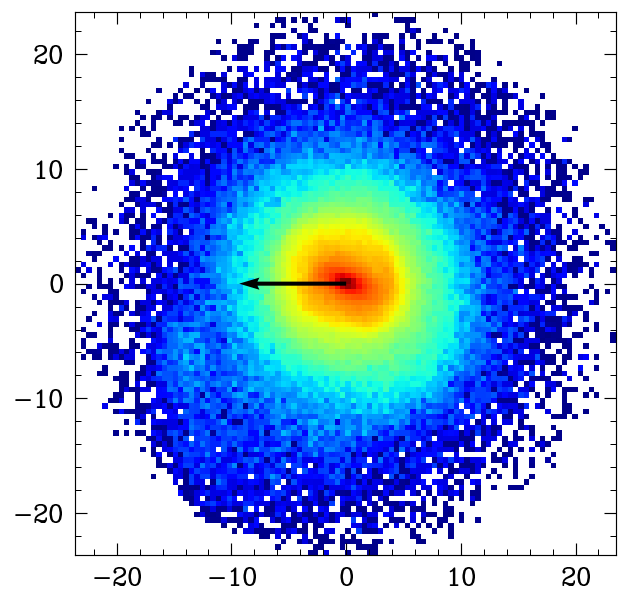

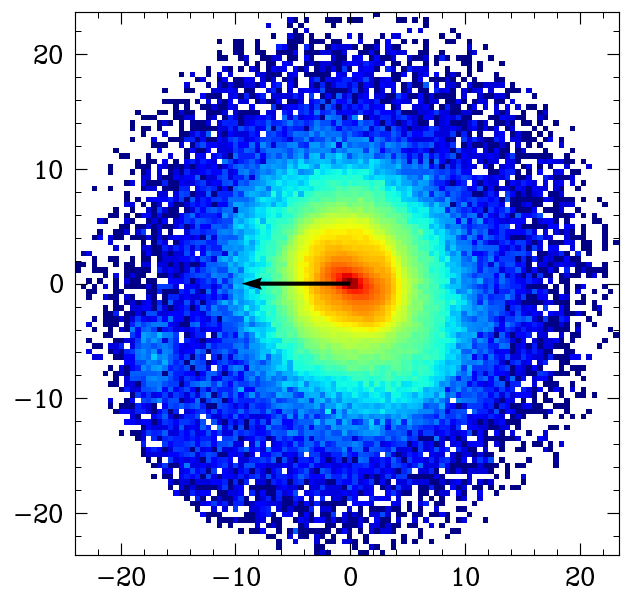

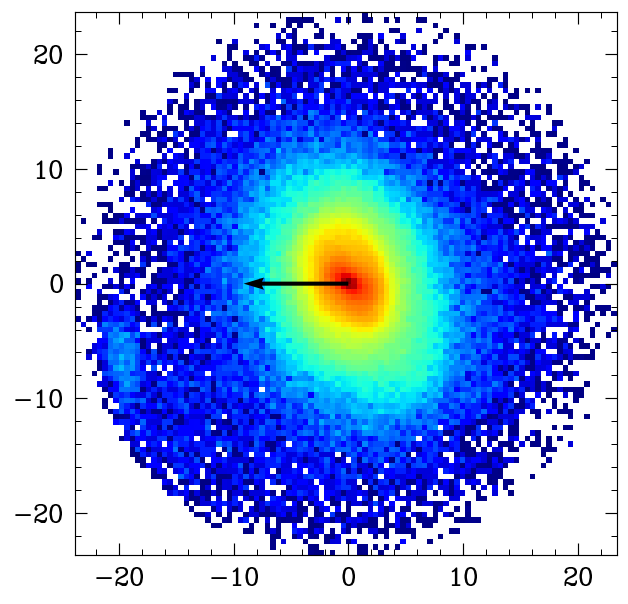

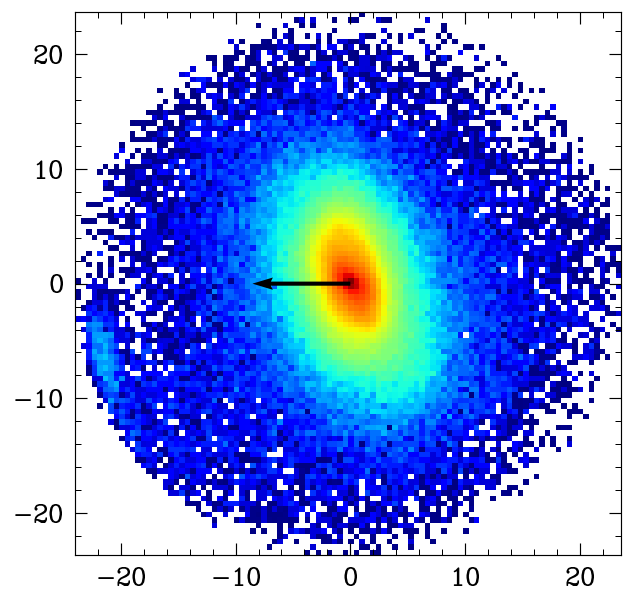

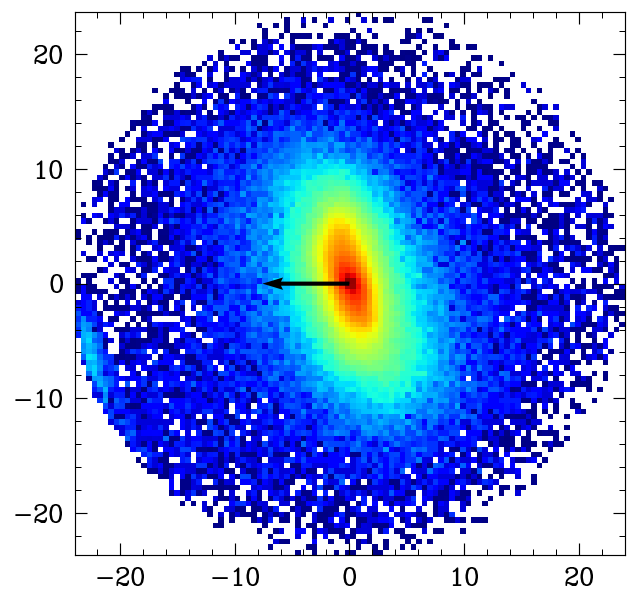

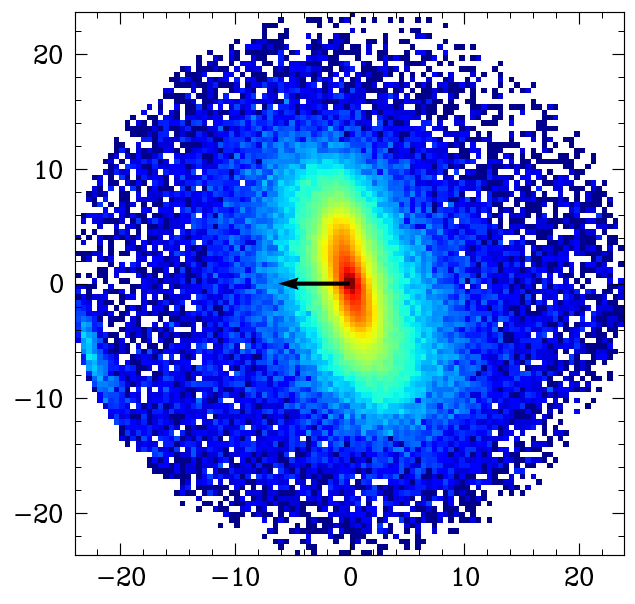

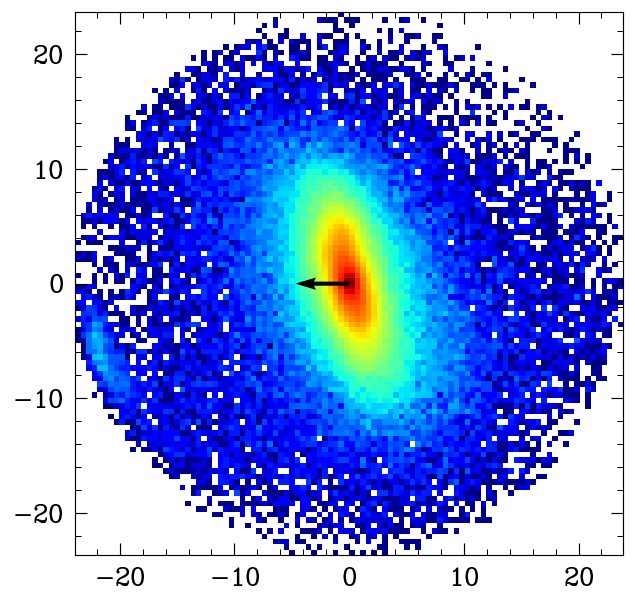

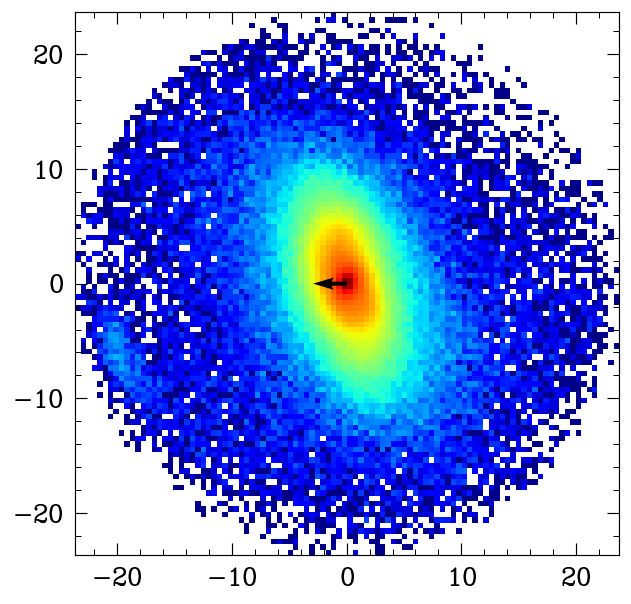

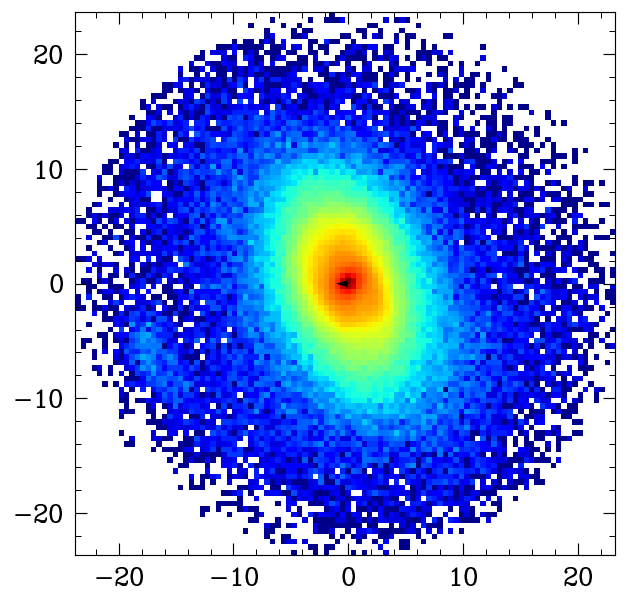

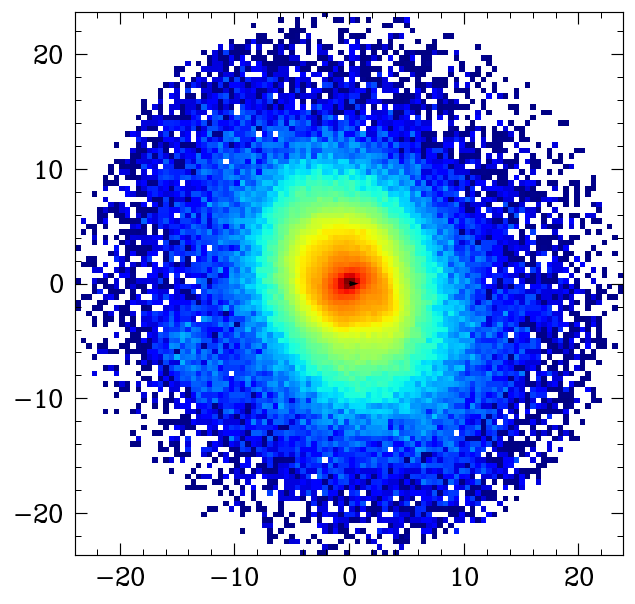

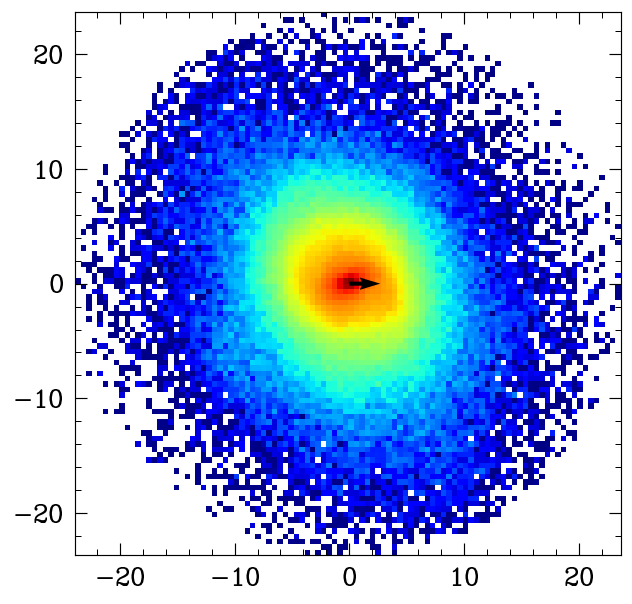

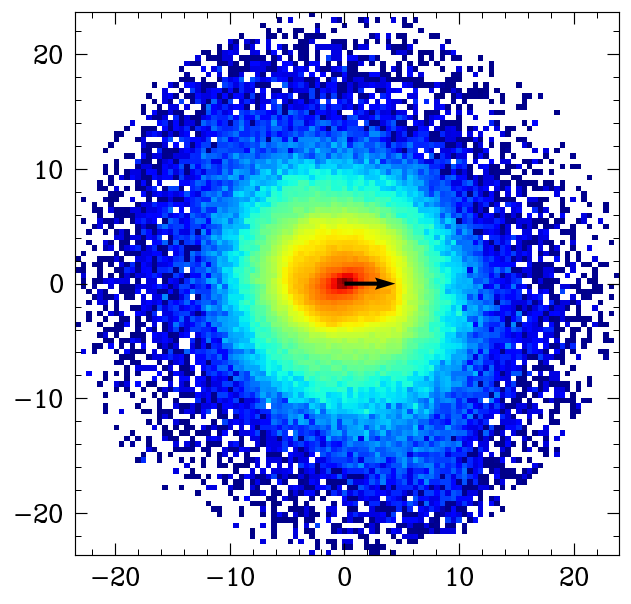

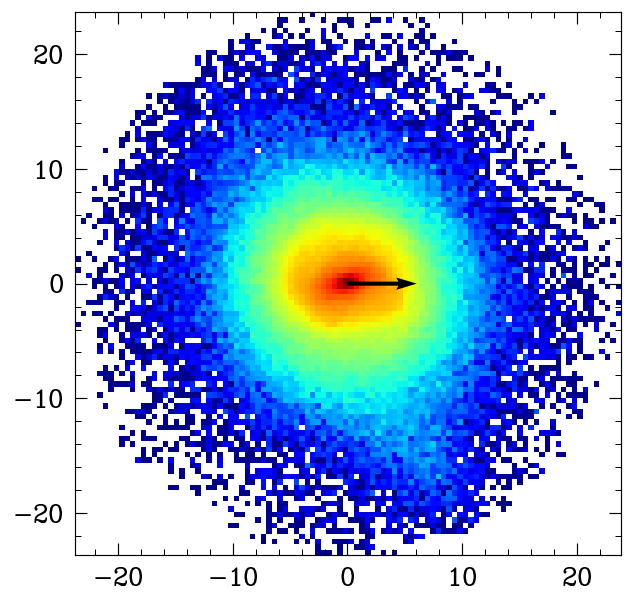

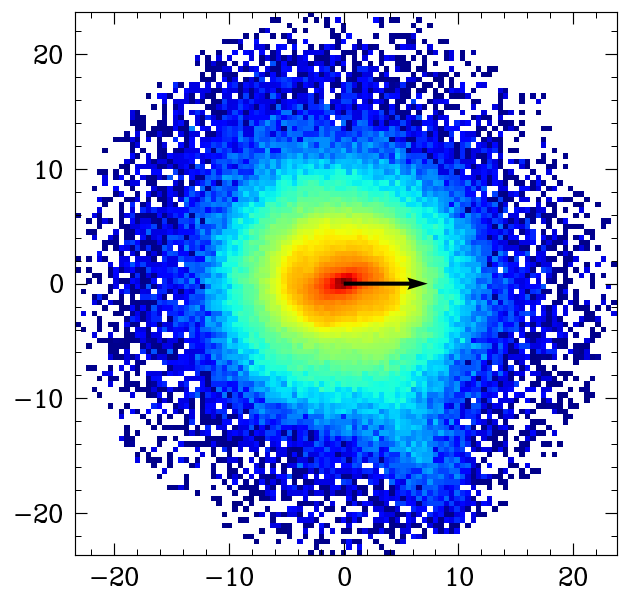

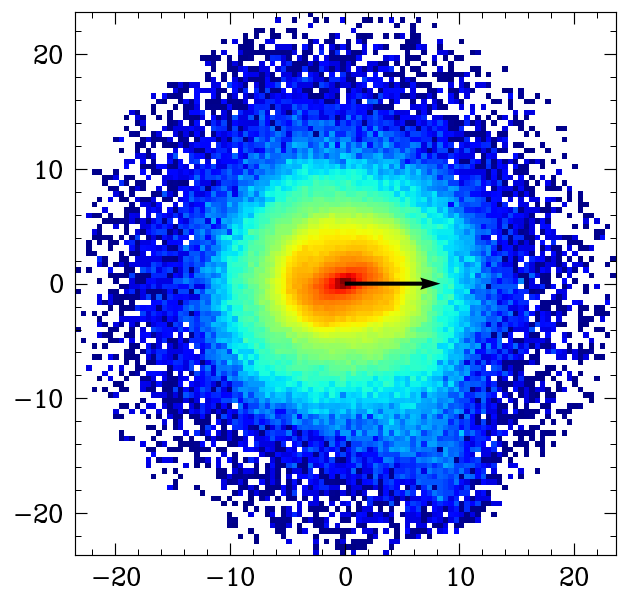

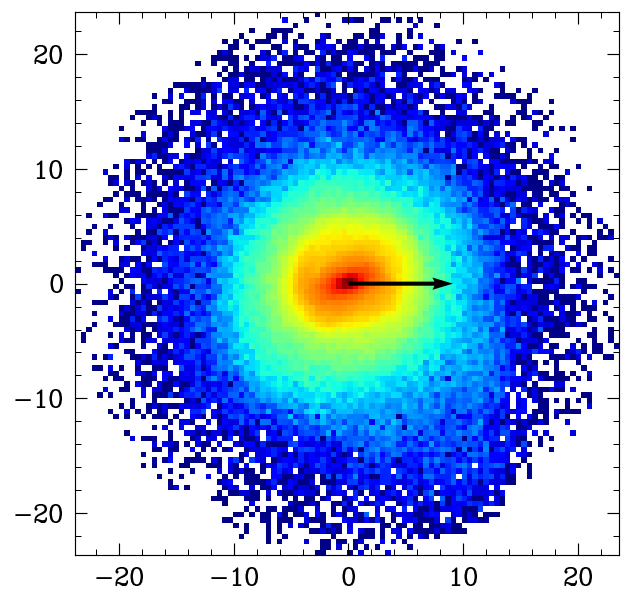

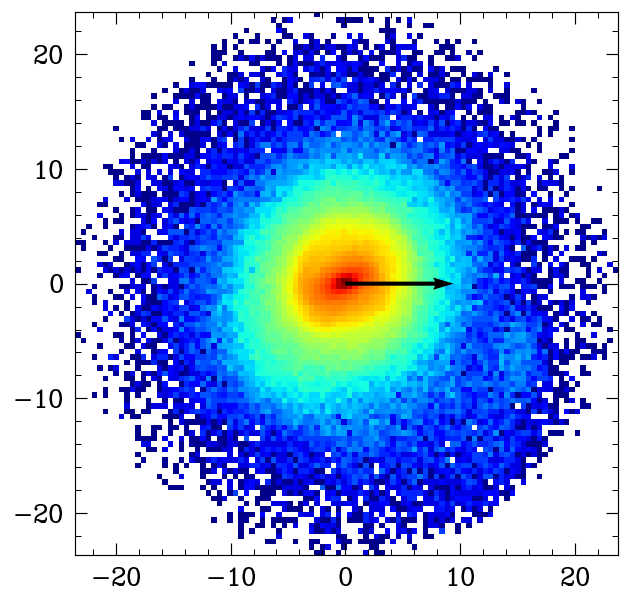

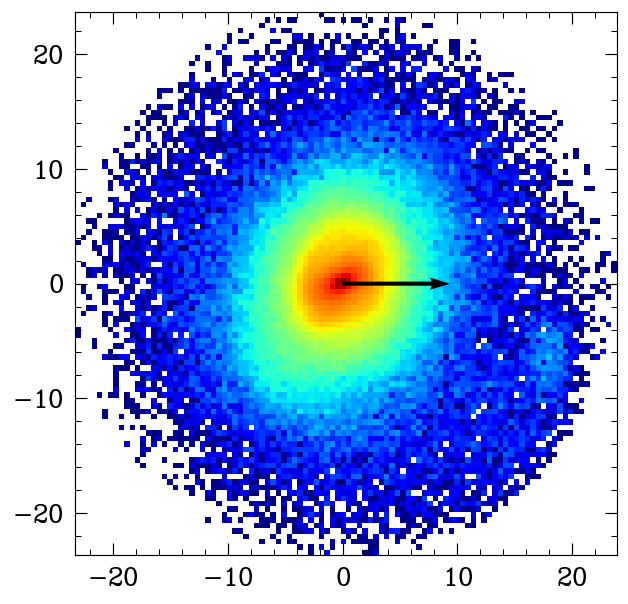

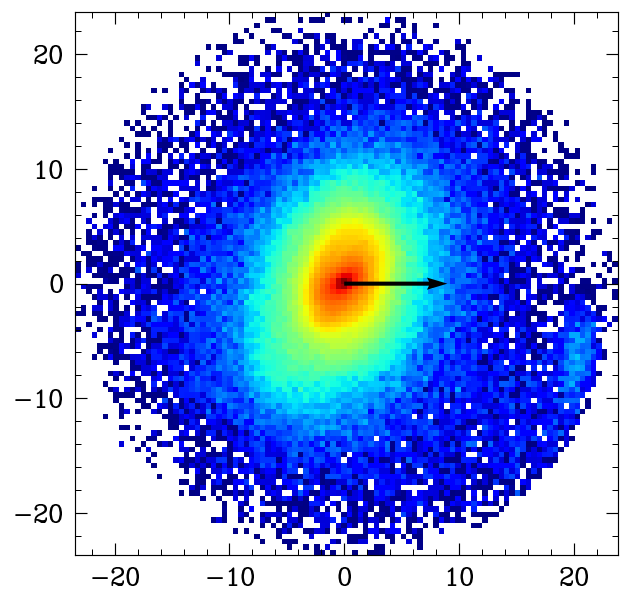

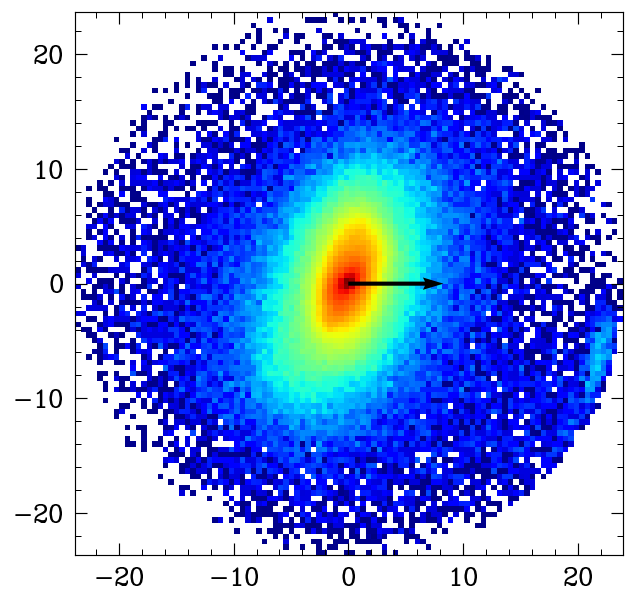

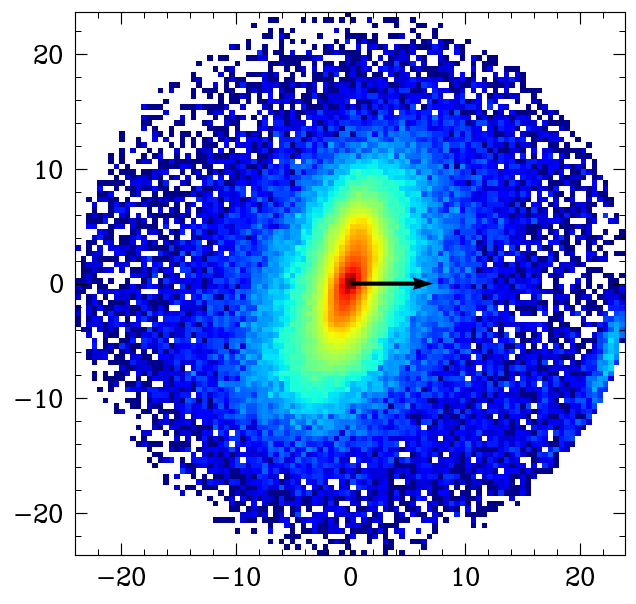

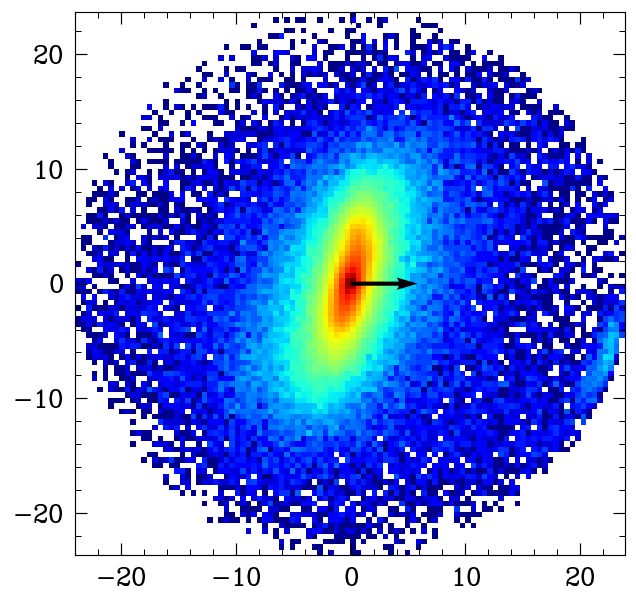

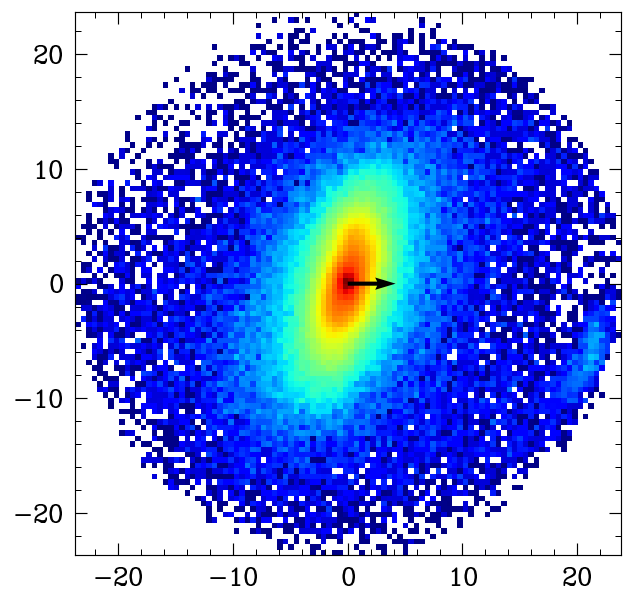

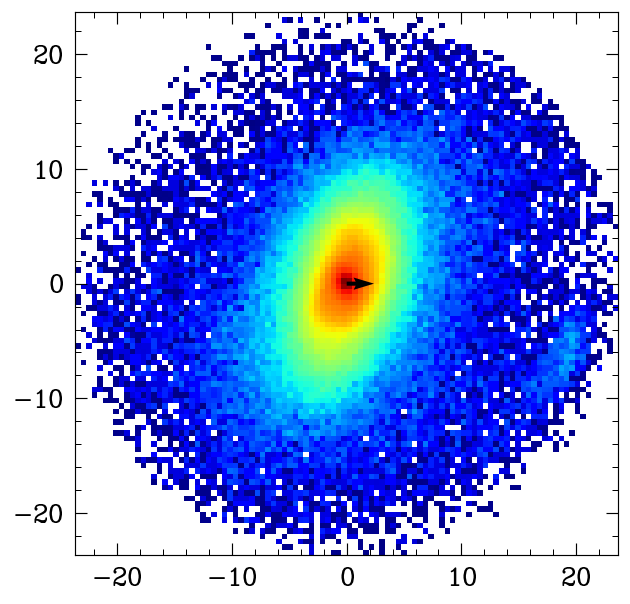

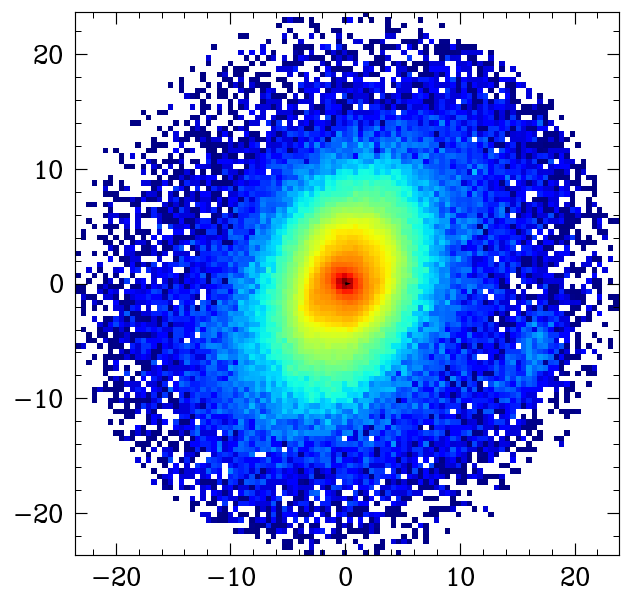

In [39]:
R = iht.Rmatrix([0,1,0], .2)
tv = [1,0,0]
idx = p[4]['r_scaled'] < .01

for i in range(40):
    h_mt,xedges,yedges = np.histogram2d(
    p[4]['Coordinates'][:,0][idx],
    p[4]['Coordinates'][:,1][idx],
    bins=100,
    weights=p[4]['Masses'][idx])#*p[4]['Temperature'][idx])
    plt.figure()
    plt.pcolormesh(xedges,yedges, (h_mt).T, norm=LogNorm())
    plt.gca().set_aspect(1)
    plt.quiver([0], [0], tv[0:1], tv[1:2], scale=5, color='k', zorder=10)
    
    tv = np.dot(tv, R.T)
    p[4]['Coordinates'] = np.dot(p[4]['Coordinates'], R.T)
    plt.savefig(f'rotatemovie/{i:03d}.png')

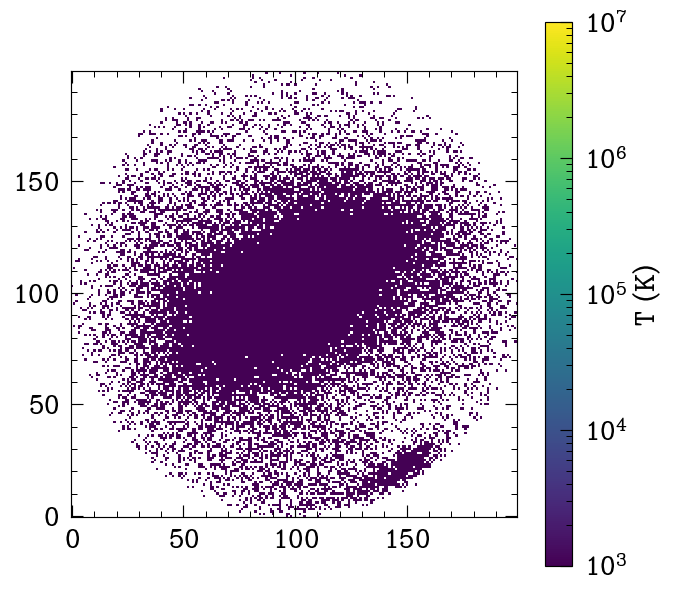

In [38]:
idx = p[4]['r_scaled'] < .1

from matplotlib.colors import LogNorm
h_mt,xedges,yedges = np.histogram2d(
    p[4]['Coordinates'][:,0][idx],
    p[4]['Coordinates'][:,1][idx],
    bins=200,
    weights=p[4]['Masses'][idx])#*p[4]['Temperature'][idx])

h_m,xedges,yedges = np.histogram2d(
    p[4]['Coordinates'][:,0][idx],
    p[4]['Coordinates'][:,1][idx],
    bins=200,
    weights=p[4]['Masses'][idx])

plt.imshow((h_mt/h_m).T,norm=LogNorm(vmin=1e3,vmax=1e7),origin='lower', cmap='viridis')
plt.gca().set_aspect(1)
plt.colorbar(label='T (K)')

## 2D VSFs

In [14]:
p[0]['Rvir']

495.79782

In [53]:
from numba import njit
import numba

In [9]:
def vsf(Coordinates, Velocities, bins=100):
    X = np.linspace(-500,500, bins)
    V = np.zeros((bins,bins))
    N = np.zeros((bins,bins))
    for i in range(len(Coordinates)):
        xi = np.digitize(Coordinates[i,0], X)
        yi = np.digitize(Coordinates[i,1], X)
        V[yi,xi] += Velocities[i,2]
        N[yi,xi] += 1
    return V/N

In [10]:
idx = p[0]['r_scaled'] < 1
V = vsf(p[0]['Coordinates'][idx], p[0]['Velocities'][idx])

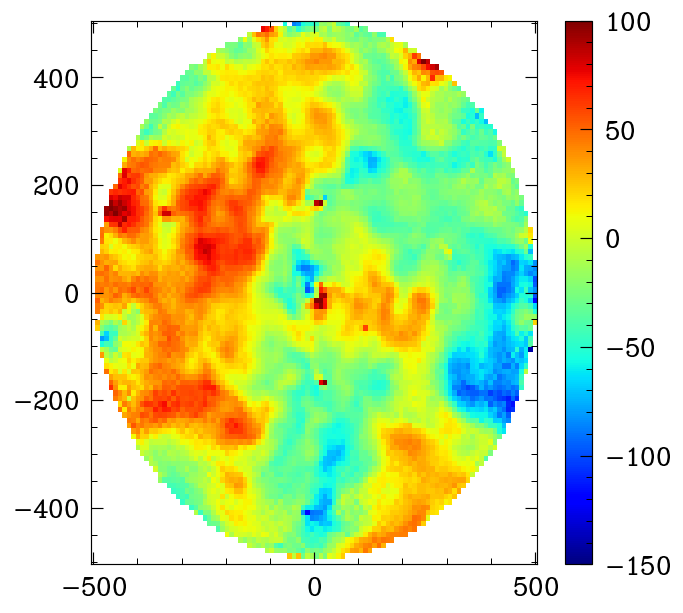

In [13]:
plt.pcolormesh(np.linspace(-500,500, 100), np.linspace(-500,500,100), V.T, vmin=-150, vmax=100)
plt.colorbar()

In [102]:
X = np.linspace(-500,500, 100)
for i in range(V.size):
    for j in range(0,i):
        
row    = index / width
column = index % width

## T calculation with $\mu$

In [72]:
y_helium = p[0]['Metallicity'][:,1] / (4*(1-p[0]['Metallicity'][:,1]))
mu = (1 + 4*y_helium) / (1+y_helium+p[0]['ElectronAbundance'])
n = p[0]['Density']*(1e10 * un.Msun/un.kpc**3) / (mu * cons.m_p)
K = (cons.k_B * p[0]['Temperature']*un.K / n**(2/3)).to(un.keV * un.cm**2).value

In [ ]:
Temperature = (mu*cons.m_p * (5/3-1) * p[0]['InternalEnergy']*(un.km/un.s)**2 / cons.k_B).to('K')

In [71]:
K.value

array([ 1309.93553921,   147.54509332, 12399.87709408, ...,
         160.40542735,   311.0448636 ,   316.66659367])

## Firefly

In [13]:
import firefly
from firefly.server import spawnFireflyServer,quitAllFireflyServers

In [46]:
process = spawnFireflyServer()

Waiting up to 10 seconds for background Firefly server to start.....

 * Restarting with stat


.done! Your server is available at - http://localhost:5500


In [54]:
from IPython.display import IFrame
url = "http://localhost:5500/combined"
IFrame(url, width=1000, height=500)

In [55]:
from firefly.data_reader import ArrayReader, SimpleFIREreader, FIREreader

In [59]:
# Load your data. Here we're creating random data.
idx = (p[0]['r_scaled']<.1)#&(np.abs(p[0]['Coordinates'][:,2])<10)
coords = p[0]['Coordinates'][idx]
my_arrayReader = ArrayReader(
    coords,
    velocities=p[0]['Velocities'][idx],
    write_to_disk=False,
    fields=p[0]['Temperature'][idx],
    field_names=['Temp'],
decimation_factor=5)

datadir is None, defaulting to /home/ias627/tools/Firefly/src/firefly/static/data/Data
Make sure each field_array (1) has a field_filter_flag (0), assuming True.
Make sure each field_array (1) has a field_colormap_flag (0), assuming True.
Make sure each field_array (1) has a field_radius_flag (0), assuming False.
PGroup_0 - 449065/2245325 particles - 2 tracked fields


In [48]:
# Load your data. Here we're creating random data.
idx = (p[4]['r_scaled']<.1)
coords = p[4]['Coordinates'][idx]
my_arrayReader = ArrayReader(
    coords,
    velocities=p[4]['Velocities'][idx],
    write_to_disk=False,
decimation_factor=5)

datadir is None, defaulting to /home/ias627/tools/Firefly/src/firefly/static/data/Data
PGroup_0 - 3147913/15739565 particles - 1 tracked fields


In [60]:
my_arrayReader.sendDataViaFlask()

PGroup_0 - 449065/2245325 particles - 2 tracked fields
Posting data on port 5500...data posted!


In [1]:
return_code = quitAllFireflyServers()

NameError: name 'quitAllFireflyServers' is not defined

In [107]:
vrad, vtheta, vphi = iht.spherical_velocities(m12i[0]['Velocities'], m12i[0]['Coordinates'])

In [118]:
idx = (0.09<m12i[0]['r_scaled'])&(m12i[0]['r_scaled']<.1)#&(np.abs(m12i[0]['Coordinates'][:,2])<10)
np.median(vphi[idx])

158.6709321984035

In [119]:
np.sum(vphi[idx] * m12i[0]['Masses'][idx])/np.sum(m12i[0]['Masses'][idx])

148.30754832459408